## Sarcasm Detection With Naive Bayes Classifier
Author: Nam Bui

In [1]:
# Typing
from __future__ import annotations
from numpy.typing import NDArray

# Collections
import numpy as np
import pandas as pd
from collections import defaultdict

# Pre-processing functions
from common import *

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# NLTK imports
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

try:
    nltk.find("tokenizers/punkt/english.pickle")
except LookupError:
    nltk.download("punkt")

try:
    nltk.find("corpora/stopwords")
except:
    nltk.download("stopwords")

try:
    nltk.find("corpora/wordnet")
except:
    nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nbui2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Load data
train_df = pd.read_json("../data/train_tokenized.json", lines=True)
val_df = pd.read_json("../data/val_tokenized.json", lines=True)
test_df = pd.read_json("../data/test_tokenized.json", lines=True)
train_df.head()

,is_sarcastic,headline,article_link,tokens
0,1,storybook romance leads to in-flight-magazine ...,https://local.theonion.com/storybook-romance-l...,"[<s>, storybook, romance, leads, to, in, -, fl..."
1,1,nation exhibits strange preoccupation with man...,https://www.theonion.com/nation-exhibits-stran...,"[<s>, nation, exhibits, strange, preoccupation..."
2,0,20 indoor wall planters to take your houseplan...,https://www.huffingtonpost.com/entry/the-best-...,"[<s>, 20, indoor, wall, planters, to, take, yo..."
3,1,prima donna species just has to have every par...,https://www.theonion.com/prima-donna-species-j...,"[<s>, prima, donna, species, just, has, to, ha..."
4,0,turkish soccer body penalizes kurdish club ami...,https://www.huffingtonpost.com/entry/turkish-s...,"[<s>, turkish, soccer, body, penalizes, kurdis..."


### Preprocessing

In [4]:
# Remove stop words
stop_words = set(stopwords.words('english'))

def remove_stopwords(sentence: list[str]) -> list[str]:
    return [w for w in sentence if w not in stop_words]

for df in [train_df, val_df, test_df]:
    df["tokens"] = df["tokens"].apply(remove_stopwords)
    
train_df.head()

,is_sarcastic,headline,article_link,tokens
0,1,storybook romance leads to in-flight-magazine ...,https://local.theonion.com/storybook-romance-l...,"[<s>, storybook, romance, leads, -, flight, -,..."
1,1,nation exhibits strange preoccupation with man...,https://www.theonion.com/nation-exhibits-stran...,"[<s>, nation, exhibits, strange, preoccupation..."
2,0,20 indoor wall planters to take your houseplan...,https://www.huffingtonpost.com/entry/the-best-...,"[<s>, 20, indoor, wall, planters, take, housep..."
3,1,prima donna species just has to have every par...,https://www.theonion.com/prima-donna-species-j...,"[<s>, prima, donna, species, every, part, natu..."
4,0,turkish soccer body penalizes kurdish club ami...,https://www.huffingtonpost.com/entry/turkish-s...,"[<s>, turkish, soccer, body, penalizes, kurdis..."


In [5]:
# Lemmatize words
lemmatizer = WordNetLemmatizer()
def lemmatize(sentence: list[str]) -> list[str]:
    return [lemmatizer.lemmatize(w) for w in sentence]

for df in [train_df, val_df, test_df]:
    df["tokens"] = df["tokens"].apply(lemmatize)
train_df.head()

,is_sarcastic,headline,article_link,tokens
0,1,storybook romance leads to in-flight-magazine ...,https://local.theonion.com/storybook-romance-l...,"[<s>, storybook, romance, lead, -, flight, -, ..."
1,1,nation exhibits strange preoccupation with man...,https://www.theonion.com/nation-exhibits-stran...,"[<s>, nation, exhibit, strange, preoccupation,..."
2,0,20 indoor wall planters to take your houseplan...,https://www.huffingtonpost.com/entry/the-best-...,"[<s>, 20, indoor, wall, planter, take, housepl..."
3,1,prima donna species just has to have every par...,https://www.theonion.com/prima-donna-species-j...,"[<s>, prima, donna, specie, every, part, natur..."
4,0,turkish soccer body penalizes kurdish club ami...,https://www.huffingtonpost.com/entry/turkish-s...,"[<s>, turkish, soccer, body, penalizes, kurdis..."


In [6]:
# Remove start and end tokens
# They're not useful for NB classification because they appear in every sample
for df in [train_df, val_df, test_df]:
    df["tokens"] = df["tokens"].apply(lambda x: x[1:-1])
train_df.head()

,is_sarcastic,headline,article_link,tokens
0,1,storybook romance leads to in-flight-magazine ...,https://local.theonion.com/storybook-romance-l...,"[storybook, romance, lead, -, flight, -, magaz..."
1,1,nation exhibits strange preoccupation with man...,https://www.theonion.com/nation-exhibits-stran...,"[nation, exhibit, strange, preoccupation, mann..."
2,0,20 indoor wall planters to take your houseplan...,https://www.huffingtonpost.com/entry/the-best-...,"[20, indoor, wall, planter, take, houseplant, ..."
3,1,prima donna species just has to have every par...,https://www.theonion.com/prima-donna-species-j...,"[prima, donna, specie, every, part, natural, h..."
4,0,turkish soccer body penalizes kurdish club ami...,https://www.huffingtonpost.com/entry/turkish-s...,"[turkish, soccer, body, penalizes, kurdish, cl..."


In [7]:
# Build vocabulary
def build_vocabulary(df) -> tuple[list[str], dict[str, int]]:
    # Get raw counts
    vocab = defaultdict(int)
    for _, tk_list in train_df["tokens"].items():
        for tk in tk_list:
            if tk not in [TK_HYPH, TK_UNK]:
                vocab[tk] += 1

    # Any word occurring less than 5 times becomes unknown
    word_list = [TK_HYPH, TK_UNK]
    word2ind = {word_list[i]: i for i in range(len(word_list))}
    for word, count in vocab.items():
        if count >= 5:
            word2ind[word] = len(word_list)
            word_list.append(word)
    return word_list, word2ind

vocab, word2ind = build_vocabulary(train_df)
len(vocab)

5219

In [8]:
# Vectorize tokens  
def vectorize_tokens(sentence: list[str]) -> NDArray:
    v = np.zeros(len(vocab), dtype=np.int8)
    i_UNK = word2ind[TK_UNK]
    for tk in sentence:
        v[word2ind.get(tk, i_UNK)] += 1
    return v

for df in [train_df, val_df, test_df]:
    df["tokens"] = df["tokens"].apply(vectorize_tokens)
train_df.head()

,is_sarcastic,headline,article_link,tokens
0,1,storybook romance leads to in-flight-magazine ...,https://local.theonion.com/storybook-romance-l...,"[0, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,nation exhibits strange preoccupation with man...,https://www.theonion.com/nation-exhibits-stran...,"[0, 3, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, ..."
2,0,20 indoor wall planters to take your houseplan...,https://www.huffingtonpost.com/entry/the-best-...,"[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ..."
3,1,prima donna species just has to have every par...,https://www.theonion.com/prima-donna-species-j...,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0,turkish soccer body penalizes kurdish club ami...,https://www.huffingtonpost.com/entry/turkish-s...,"[0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Train

In [9]:
# Vectorize data
train_X = np.vstack(train_df["tokens"])
train_Y = np.stack(train_df["is_sarcastic"], dtype=np.int8)
val_X = np.vstack(val_df["tokens"], dtype=np.int8)
val_Y = np.stack(val_df["is_sarcastic"], dtype=np.int8)
test_X = np.vstack(test_df["tokens"], dtype=np.int8)
test_Y = np.stack(test_df["is_sarcastic"], dtype=np.int8)

In [10]:
def evaluate_confusion_matrix(cm: NDArray) -> None:
    # Calculate and print metrics based off confusion matrix
    precision = (cm[0][0]) / (cm[0][0] + cm[1][0])
    recall = (cm[0][0]) / (cm[0][0] + cm[0][1])
    print(f"Accuracy: {(cm[0][0] + cm[1][1]) / np.sum(cm):.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {(2 * precision * recall) / (precision + recall):.4f}")

In [11]:
alphas = np.arange(0.5, 3.5, 0.5)
classifiers = {}
for a in alphas:
    print(f"Alpha: {a}")
    classifier = MultinomialNB(alpha=a)
    classifier.fit(train_X, train_Y)
    classifiers[a] = classifier
    print(f"Training set performance:")
    train_pred = classifier.predict(train_X)
    train_cm = confusion_matrix(train_Y, train_pred)
    evaluate_confusion_matrix(train_cm)
    print(f"Validation set performance:")
    val_pred = classifier.predict(val_X)
    val_cm = confusion_matrix(val_Y, val_pred)
    evaluate_confusion_matrix(val_cm)
    print("")

Alpha: 0.5
Training set performance:
Accuracy: 0.8536
Precision: 0.8657
Recall: 0.8527
F1: 0.8592
Validation set performance:
Accuracy: 0.8020
Precision: 0.8187
Recall: 0.7988
F1: 0.8086

Alpha: 1.0
Training set performance:
Accuracy: 0.8525
Precision: 0.8639
Recall: 0.8526
F1: 0.8582
Validation set performance:
Accuracy: 0.8039
Precision: 0.8207
Recall: 0.8005
F1: 0.8105

Alpha: 1.5
Training set performance:
Accuracy: 0.8510
Precision: 0.8621
Recall: 0.8517
F1: 0.8569
Validation set performance:
Accuracy: 0.8043
Precision: 0.8211
Recall: 0.8008
F1: 0.8108

Alpha: 2.0
Training set performance:
Accuracy: 0.8492
Precision: 0.8604
Recall: 0.8500
F1: 0.8552
Validation set performance:
Accuracy: 0.8045
Precision: 0.8205
Recall: 0.8021
F1: 0.8112

Alpha: 2.5
Training set performance:
Accuracy: 0.8475
Precision: 0.8580
Recall: 0.8493
F1: 0.8536
Validation set performance:
Accuracy: 0.8053
Precision: 0.8217
Recall: 0.8025
F1: 0.8120

Alpha: 3.0
Training set performance:
Accuracy: 0.8461
Precis

Since the classifier with smoothing parameter $ \alpha = 1.5 $ performs the best on validation set,
we will evaluate it on test set.

In [12]:
ALPHA = 1.0
print(f"Evaluation of NB with alpha = {ALPHA}")
test_pred = classifiers[ALPHA].predict(test_X)
test_cm = confusion_matrix(test_Y, test_pred)
evaluate_confusion_matrix(test_cm)

Evaluation of NB with alpha = 1.0
Accuracy: 0.7926
Precision: 0.8059
Recall: 0.7952
F1: 0.8005


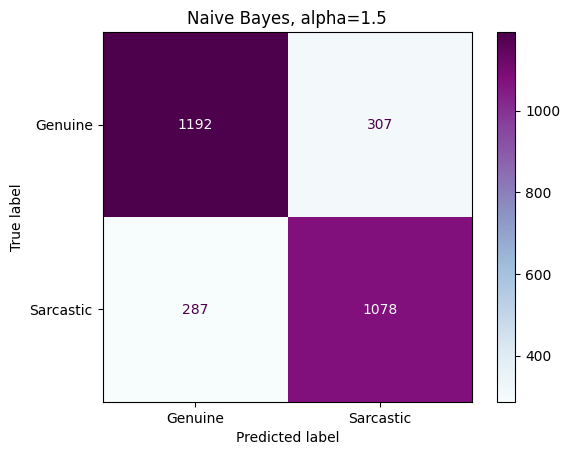

In [13]:
cm_plot = ConfusionMatrixDisplay(test_cm)
cm_plot.display_labels = ["Genuine", "Sarcastic"]
cm_plot.plot(cmap = "BuPu")
cm_plot.ax_.set_title("Naive Bayes, alpha=1.5")
plt.show()